# **训练长短时记忆循环神经网络预测音乐的节拍（Predict the Beats with LSTM）**

Madmom 对音乐信息的提取主要用到两方面技术，一是数字信号处理，二是机器学习。数字信号处理的部分其实也可以理解为是在对机器学习所需的训练数据做预处理，也就是说，训练数据用的不是原始音频数据，而是经傅立叶转换等处理后得到的 Mel 频谱，对应 [音乐频谱实时分析](2M_realtimeSpectrogram.ipynb)笔记本中的内容。

具体到机器学习的部分，Madmom 使用的核心技术之一是 **循环神经网络（Recurrent Neural Networks）**，具体可以参看附录 4 和附录 5 神经网络与循环神经网络相关的学习笔记。

使用 Madmom 库分析音乐节拍时，利用的就是作者提前训练好的神经网络模型，可以参看作者的[这篇文章](02_RNN_DBN_MultimodelBeatTracking2014.pdf)。我们自然不清楚具体的训练过程，但是参考作者[这篇识别音乐起始音符的教程](https://github.com/slychief/ismir2018_tutorial/blob/master/Part_3b_RNN_Onset_Detection.ipynb)，开始下面的模型训练。

&emsp;

具体地：

+ 参照作者使用 [**Keras**](https://keras.io/) 机器学习框架

+ [**Google Colab GPU 加速**](https://colab.research.google.com/)（为保证持续稳定的连接，购买了 pro 版）

    作者教程中使用的是 CPU，看结果速度也非常快，但我实际无论本地还是 Colab 环境下 CPU 训练的用时都过长，基本是作者的 20 倍
    
+ 数据存储配套使用 [**Goolge Drive**](https://www.google.com/drive/)

+ 训练数据使用 [**Ballroom Datasets**](https://github.com/CPJKU/BallroomAnnotations)

    链接打开对应的是 Madmom 作者及同事手动标记的该数据库对应节拍标签，下方说明中有提供配套音频数据下载链接，删除重复的音频文件，最终共 515 个音频文件

&emsp;

**确认是否使用了 GPU 加速**

In [2]:
# 这个 cell 内的代码只在 Colab 中适用，jupyter-lab 中报错
# 参看这里：https://stackoverflow.com/questions/59514268/usageerror-line-magic-function-tensorflow-version-not-found

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('没有发现 GPU 设备')
print('发现 GPU 设备：{}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


&emsp;

**安装依赖库**

Colab 线上服务器环境下默认没有的依赖需要自己先安装

In [ ]:
!pip3 install madmom

In [ ]:
import numpy as np
import madmom
import tensorflow as tf
import keras
import warnings
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(15,8)

&emsp;

**连接谷歌云盘**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

&emsp;

**基本参数**

In [ ]:
FPS = 100
BEAT_PATH = 'drive/MyDrive/BallroomBeats'

&emsp;

**训练数据准备**

+ 将预处理后的频谱、正确节拍标记以及对应数据文件名作为列表存储

+ 定义训练数据预处理方法

+ 定义提取和分割标记文件的方法

+ 定义用于交叉验证的事先已分为 8 组（fold）数据文件的方法

In [ ]:
class Dataset(object):

    def __init__(self, path, audio_suffix='.wav', annotation_suffix='.beats'):
        self.path = path
        # 读取并以列表形式储存音频和标记文件
        audio_files = madmom.utils.search_files(self.path + '/audio', audio_suffix)
        annotation_files = madmom.utils.search_files(self.path + '/annotations', annotation_suffix)
        # 匹配音频和标记文件，并储存文件名
        self.files = []
        self.audio_files = []
        self.annotation_files = []
        for annotation_file in annotation_files:
            # 按标记文件匹配对应音频文件
            matches = madmom.utils.match_file(annotation_file, audio_files, suffix=annotation_suffix, match_suffix=audio_suffix)
            if len(matches) == 1:
                audio_file = matches[0]
                self.audio_files.append(audio_file)
                self.annotation_files.append(annotation_file)
                self.files.append(os.path.basename(annotation_file[:-len(annotation_suffix)]))
            else:
                warnings.warn('跳过 %s，没有找到对应音频文件' % annotation_file)


    def load_splits(self, path=None, fold_suffix='.fold'):
        path = path if path is not None else self.path + '/splits'
        self.split_files = madmom.utils.search_files(path, fold_suffix, recursion_depth=1)
        self.folds = []
        for i, split_file in enumerate(self.split_files):
            fold_idx = []
            with open(split_file) as f:
                for file in f:
                    file = file.strip()
                    try:
                        idx = self.files.index(file)
                        fold_idx.append(idx)
                    except ValueError:
                        warnings.warn('没有找到匹配的音频/标记文件：%s' % file)
                        continue
            self.folds.append(np.array(fold_idx))

    def pre_process(self, pre_processor):
        self.x = [pre_processor(file) for file in self.audio_files]

    
    def load_annotations(self, widen=None):
        self.annotations = [madmom.io.load_beats(file) for file in self.annotation_files]



&emsp;

**创建 Dataset**

In [ ]:
# 标记文件原本就多于音频文件，音频文件中又删去了一些重复的文件，所以会报告说有一些没找到
beats_db = Dataset(BEAT_PATH, audio_suffix='.wav')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-AnaBelen_Veneo-15.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-Ballroom_Magic-03.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-Chrisanne2-12.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-Fire-09.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-Latin_Jam-08.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 跳过 drive/MyDrive/BallroomBeats/annotations/Albums-Latin_Jam-13.beats，没有找到对应音频文件
/usr/local/lib/python3.7/dist-packages/ipykern

&emsp;

**音频数据预处理**

取 1024、2048、4096 3 种时间窗，经 Mel 过滤得到 20 band 频谱

In [ ]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor
from madmom.audio.filters import MelFilterbank

class BeatsPreProcessor(SequentialProcessor):

    def __init__(self, frame_sizes=[1024, 2048, 4096]):
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        multi = ParallelProcessor([])
        for frame_size in frame_sizes:
            frames = FramedSignalProcessor(frame_size=frame_size)
            stft = ShortTimeFourierTransformProcessor()
            filt = FilteredSpectrogramProcessor(filterbank=MelFilterbank, num_bands=20)
            spec = LogarithmicSpectrogramProcessor()
            diff = SpectrogramDifferenceProcessor(positive_diffs=True, stack_diffs=np.hstack)
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        super(BeatsPreProcessor, self).__init__((sig, multi, np.hstack))

pp = BeatsPreProcessor()


In [ ]:
beats_db.pre_process(pp)

/usr/local/lib/python3.7/dist-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [ ]:
beats_db.load_annotations()

&emsp;

**将预处理后的整个 beats_db 对象打包保存**

非常重要！因为 Colab 连接中断重启后之前的数据如果没有保存就全部丢失了，利用 pickle 可以快速重复调用前面以准备好的训练数据

In [ ]:
# 打包保存
pickle.dump(beats_db, open('drive/MyDrive/BallroomBeats/beats_db.pkl', 'wb'), protocol=2)

In [ ]:
# 提取调用
# 运行前先运行一下 Dataset 类的定义函数
 
beats_db = pickle.load(open('drive/MyDrive/BallroomBeats/beats_db.pkl', 'rb'))

&emsp;

**数据序列**

利用 Keras 的 Sequence 类，实现以下功能：

+ 将节拍标记信息转为 RNN 模型训练所需的目标（target）

+ 返回给定 batch 大小的预处理后的输入数据及对应标记数据

+ 限制输入序列数据的最大长度


In [ ]:
# 从 keras 导入 Sequence 会报错，要加上前缀 tensorflow
# 参考这里：https://stackoverflow.com/questions/67555954/cannot-import-name-sequence-from-keras-utils

from tensorflow.keras.utils import Sequence

class DataSequence(Sequence):
  
    mask_value = -999              # 只有当 batch size 大于 1 的时候才会用到

    def __init__(self, x, y, batch_size=1, max_seq_length=None, fps=FPS):
        self.x = x
        self.y = [madmom.utils.quantize_events(o, fps=fps, length=len(d)) for o, d in zip(y, self.x)]
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        # 如果 batch_size 大于 1，因为一个 batch 内的序列原本长度不同，所以要padding为全部等长的序列，这里用的方法是把长序列后面大于最大
        # 长度的部分去掉
        if self.batch_size > 1:
            x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.max_seq_length, dtype=np.float32, padding='post', truncating='post', value=self.mask_value)
            y = keras.preprocessing.sequence.pad_sequences(y, maxlen=self.max_seq_length, dtype=np.int32, padding='post', truncating='post', value=self.mask_value)
        return np.array(x), np.array(y)[..., np.newaxis]

&emsp;

定义一个帮助类，用来确保训练、验证和测验三类数据文件没有重复，返回的是索引值

In [ ]:
class Fold(object):

    def __init__(self, folds, fold):
        self.folds = folds
        self.fold = fold

    @property
    def test(self):
        # 测验数据用 fold N
        return np.unique(self.folds[self.fold])

    @property
    def val(self):
        # 验证数据用 fold N + 1
        return np.unique(self.folds[(self.fold + 1) % len(self.folds)])

    @property
    def train(self):
        # 剩下的全部用作训练数据
        train = np.hstack((beats_db.folds))
        train = np.setdiff1d(train, self.val)
        train = np.setdiff1d(train, self.test)
        return train

&emsp;

**训练神经网络**

+ **3 层 双向 LSTM 隐藏层（每层 25 个神经元）**

    教程中作者用的是 keras 中的 SimpleRNN 模型，而非 LSTM， 但是为了使用 GPU 加速，这里采用了 LSTM 模型，因为 Keras 中只有 LSTM 和 GRU 本身自带对 GPU 的支持。另外为了使用 CuDNN 内核加速，LSTM 模型的某些参数设置也是固定不能改变的，具体见[官方文档说明](https://keras.io/guides/working_with_rnns/)

+ 输入层 20 X 6 = 120 个神经元

+ 输出层 1 个神经元，二分判断每个 frame 是否包含 1 个节拍

+ 学习速率先取值 **0.01**

+ 损失函数使用二分交叉熵：**binary_crossentropy**

+ 采用**随机梯度下降（SGD）**算法优化损失函数

In [ ]:
# 训练的模型数据保存在谷歌云盘中
basedir = 'drive/MyDrive/BeatsModels'
learning_rate = 0.01

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, Masking, LSTM, Dense

&emsp;

以 fold 为单位，生成训练和验证数据

全部 685 个音频数据被提前分为了 8 个 fold，N 从 0 开始取值，N fold 作为测验数据使用，N + 1 fold 作为验证数据使用，剩下全部数据作为训练数据用。N 从 0 取到 7 训练 8 次，最终生成 8 个模型。

In [ ]:
def train_data(num_fold):
    num_fold = int(num_fold)
    fold = Fold(beats_db.folds, num_fold)
    train = DataSequence([beats_db.x[i] for i in fold.train], [beats_db.annotations[i] for i in fold.train], batch_size=1, max_seq_length=60*FPS)
    val = DataSequence([beats_db.x[i] for i in fold.val], [beats_db.annotations[i] for i in fold.val], batch_size=1, max_seq_length=60*FPS)
    return fold, train, val

&emsp;

构建模型，准备训练

In [ ]:
def modelSGD_training():
    model = Sequential()
    model.add(Masking(input_shape=(None, train[0][0].shape[-1]), mask_value=train.mask_value))
    model.add(Bidirectional(LSTM(units=25, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=25, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=25, return_sequences=True)))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=5, momentum=0.9), metrics=['binary_accuracy'])
  
    verbose = 0
    name = '%s/lr_%s/fold_%s/' % (basedir, str(learning_rate).replace('.',''), str(fold.fold))
  
    mca = keras.callbacks.ModelCheckpoint(name + 'model_{epoch:02d}.h5', monitor='loss', save_best_only=False, verbose = verbose)
    mcb = keras.callbacks.ModelCheckpoint(name + 'model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)
    mcv = keras.callbacks.ModelCheckpoint(name + 'model_best_val.h5', monitor='val_loss', save_best_only=True, verbose=verbose)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=verbose)
    tb = keras.callbacks.TensorBoard(log_dir=name+'logs', write_graph=True, write_images=True)
    history = model.fit_generator(train, steps_per_epoch=len(train), epochs=100, shuffle=True, validation_data=val, validation_steps=len(val), callbacks=[mca, mcb, mcv, es, tb])
    model.save(name+'model_final.h5')

In [ ]:
# 下面 num_fold 的取值之所以从 3 开始是因为前面三组用的 Adam optimizer，从 3 开始换回了 SGD
# 因为数据量大，训练非常耗时，另外应该和超参数的初始取值相关，从下面返回结果可以看出， 100 个 epoch
# 一个没少全部跑完了，所以目前只得到 1 个 fold 对应的模型
for num_fold in [3, 4, 5, 6, 7]:
    fold, train, val = train_data(num_fold)
    modelSGD_training()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
515/515 [==============================] - 311s 451ms/step - loss: 0.1108 - binary_accuracy: 0.9773 - val_loss: 0.1064 - val_binary_accuracy: 0.9780
Epoch 2/100
515/515 [==============================] - 220s 427ms/step - loss: 0.0998 - binary_accuracy: 0.9796 - val_loss: 0.1058 - val_binary_accuracy: 0.9780
Epoch 3/100
515/515 [==============================] - 220s 428ms/step - loss: 0.0994 - binary_accuracy: 0.9796 - val_loss: 0.1054 - val_binary_accuracy: 0.9780
Epoch 4/100
515/515 [==============================] - 221s 430ms/step - loss: 0.0991 - binary_accuracy: 0.9796 - val_loss: 0.1052 - val_binary_accuracy: 0.9780
Epoch 5/100
515/515 [==============================] - 221s 429ms/step - loss: 0.0987 - binary_accuracy: 0.9796 - val_loss: 0.1050 - val_binary_accuracy: 0.9780
Epoch 6/100
515/515 [==============================] - 220s 427ms/step - loss: 0.0984 - binary_accuracy: 0.9796 - val_loss: 0.1047 - val_binary_accuracy: 0.9780
Epoch 7/100
515/515 [=============

&emsp;

**附：**


**训练数据长什么样子**

以一个音频文件为例，这就是预处理后神经网络模型的输入数据

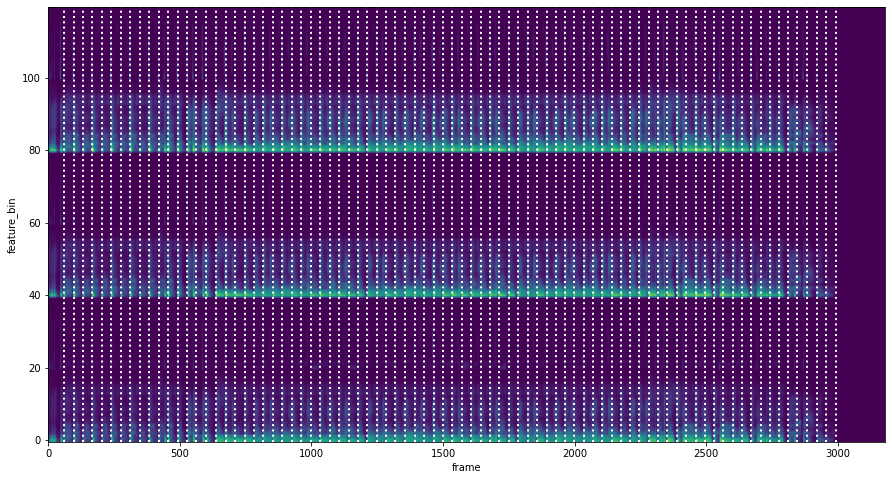

In [ ]:
example = 'Media-103611'
example_idx = beats_db.files.index(example)

plt.imshow(beats_db.x[example_idx].T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('feature_bin')
for ann in beats_db.annotations[example_idx]:
    plt.axvline(x=ann*FPS, color='w', linestyle=':', linewidth=2)


**关于 Optimizer**

+ [Optimizers Explained - Adam, Momentum and Stochastic Gradient Descent](https://mlfromscratch.com/optimizers-explained/#/)

+ [An overview of gradient descent optimization algorithms](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)